# Chapter 15: Dropout

A dropout layer disables some neurons, and others are unchanged.

The idea, similarly to regularization, is to prevent a NN from becoming too dependent on any neuron, and prevent any neuron to be relied upon entirely a specific instance (common if a model overfits the training data).

Dropout helps prevent overfitting, as the model can't use specific neurons to memorize certain samples.

The dropout layer does not truly disable neurons, but instead zeroes their outputs. In other words, dropout does not decrease the number of neurons used, nor does it make the training process twice as fast when half the neurons are disabled.


## 15.1. Forward Pass

We will “turn off” neurons with a filter that is an array with the same shape as the layer output but filled with numbers drawn from a Bernoulli distribution.

A Bernoulli distribution is a binary (or discrete) probability distribution where we can get a value of 1 with a probability of $p$ and value of 0 with a probability of $q$.

The probability of this value being 1 is $p$, and the probability of it being 0 is $q = 1 - p$, therefore:

$$
P(r_i = 1) = p
$$

$$
P(r_i = 1) = q = 1 - p = 1 - P(r_i = 1)
$$

$$
r_i \sim Bernoulli(p)
$$

We are returned an array filled with values of 1 with a probability of $p$ and otherwise values of 0 . We then apply this filter to the output of a layer we want to add dropout to.

<center><img src='./image/15-1.png' style='width: 60%'/><font color='gray'><i>Example model with no dropout applied.</i></font></center>

<center><img src='./image/15-2.png' style='width: 60%'/><font color='gray'><i>Example model with 0.5 dropout.</i></font></center>

<center><img src='./image/15-3.png' style='width: 60%'/><font color='gray'><i>Example model with 0.9 dropout.</i></font></center>

<b>Example in pure Python</b>



In [2]:
import random
dropout_rate = 0.5
# Example output containing 10 values
example_output = [ 0.27 , - 1.03 , 0.67 , 0.99 , 0.05 , - 0.37 , - 2.01 , 1.13 , - 0.07 , 0.73 ]

# Repeat as long as necessary
while True :
    # Randomly choose index and set value to 0
    index = random.randint( 0 , len (example_output) - 1 )
    example_output[index] = 0

    # We might set an index that already is zeroed
    # There are different ways of overcoming this problem,
    # for simplicity we count values that are exactly 0
    # while it's extremely rare in real model that weights
    # are exactly 0, this is not the best method for sure
    dropped_out = 0
    for value in example_output:
        if value == 0 :
            dropped_out += 1

    # If required number of outputs is zeroed - leave the loop
    if dropped_out / len (example_output) >= dropout_rate:
        break

print (example_output)

[0.27, 0, 0, 0.99, 0, -0.37, -2.01, 0, 0, 0.73]


<b>Example using Numpy</b>

If we don’t use dropout during prediction, all neurons will output their values, and this state won’t match the state seen during training, since the sums will be statistically about twice as big.

Scale the data back up after a dropout, during the training phase, to mimic the mean of the sum when all of the neurons output their values.

In [3]:
import numpy as np

dropout_rate = 0.2
example_output = np.array([ 0.27 , - 1.03 , 0.67 , 0.99 , 0.05 , - 0.37 , - 2.01 , 1.13 , - 0.07 , 0.73 ])
print ( 'sum initial : ', sum (example_output) )

sums = []
for i in range ( 10000 ):
    example_output2 = example_output * np.random.binomial( 1 , 1 - dropout_rate, example_output.shape) / ( 1 - dropout_rate)
    sums.append( sum (example_output2))

print ( 'mean sum: ', np.mean(sums) )


sum initial :  0.36000000000000015
mean sum:  0.3543187500000002


## 15.2. Backward Pass

The last missing piece to implement dropout as a layer is a backward pass method. As before, we need to calculate the partial derivative of the dropout operation.

When the value of element $r_i$ equals 1, its function and derivative becomes the neuron’s output $z$, compensated for the loss value by $1-q$, where $q$ is the dropout rate.

$$
f(z,q) = \frac{z}{1 - q} \quad \to \quad \frac{∂}{∂z} \big[ \frac{z}{1-q}  \big] = \frac{1}{1-q} \cdot \frac{∂}{∂z} z = \frac{1}{1-q} \cdot 1 = \frac{1}{1-q}
$$

When $r_i = 0$:

$$
f(z,q) = 0 \quad \to \quad \frac{∂}{∂z} 0 = 0
$$

Let's combine both cases and denote <i>Dropout</i> as <i>Dr</i>:

$$
Dr_i =
\begin{cases}
\frac{z_i}{1 - q} & r_i = 1 \\
0 & r_i = 0
\end{cases} 
\quad \to \quad 
\frac{∂}{∂z_i} Dr_i =
\begin{cases}
\frac{1}{1 - q} & r_i = 1 \\
0 & r_i = 0
\end{cases}
\ \ = \ \ \frac{r_i}{1-q}
$$

$i$ denotes the index of the given input (and the layer output). When we write a derivative of the dropout function this way, we can simplify it to a value from the Bernoulli distribution divided by $1-q$, which is identical to our scaled mask, the function the dropout applies during the forward pass, as it’s also either $1$ divided by $1-q$, or $0$.

Thus, we can save this mask during the forward pass and use it with the chain rule as the gradient of this function.

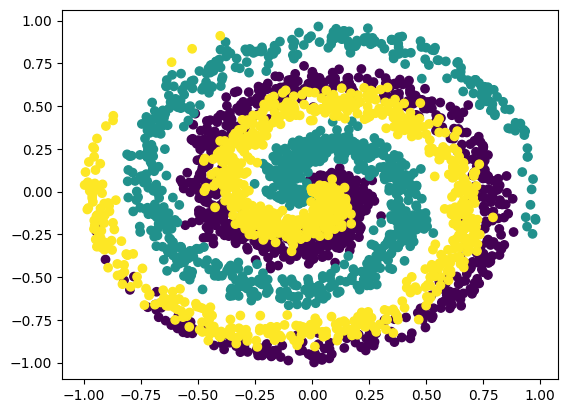

epoch: 0, acc: 0.324, loss: 1.099 (data_loss: 1.099, reg_loss: 0.000), lr: 0.05
epoch: 100, acc: 0.564, loss: 0.917 (data_loss: 0.894, reg_loss: 0.023), lr: 0.04975371909050202
epoch: 200, acc: 0.595, loss: 0.870 (data_loss: 0.840, reg_loss: 0.030), lr: 0.049507401356502806
epoch: 300, acc: 0.623, loss: 0.844 (data_loss: 0.814, reg_loss: 0.030), lr: 0.0492635105177595
epoch: 400, acc: 0.651, loss: 0.823 (data_loss: 0.795, reg_loss: 0.028), lr: 0.04902201088288642
epoch: 500, acc: 0.647, loss: 0.829 (data_loss: 0.802, reg_loss: 0.026), lr: 0.048782867456949125
epoch: 600, acc: 0.631, loss: 0.838 (data_loss: 0.812, reg_loss: 0.026), lr: 0.04854604592455945
epoch: 700, acc: 0.664, loss: 0.798 (data_loss: 0.773, reg_loss: 0.025), lr: 0.048311512633460556
epoch: 800, acc: 0.644, loss: 0.821 (data_loss: 0.797, reg_loss: 0.024), lr: 0.04807923457858551
epoch: 900, acc: 0.627, loss: 0.812 (data_loss: 0.788, reg_loss: 0.024), lr: 0.04784917938657352
epoch: 1000, acc: 0.657, loss: 0.811 (data_lo

epoch: 8400, acc: 0.688, loss: 0.722 (data_loss: 0.705, reg_loss: 0.017), lr: 0.03521250748265784
epoch: 8500, acc: 0.701, loss: 0.703 (data_loss: 0.686, reg_loss: 0.017), lr: 0.035088950489490865
epoch: 8600, acc: 0.707, loss: 0.711 (data_loss: 0.694, reg_loss: 0.017), lr: 0.0349662575614532
epoch: 8700, acc: 0.692, loss: 0.719 (data_loss: 0.702, reg_loss: 0.017), lr: 0.034844419666190465
epoch: 8800, acc: 0.686, loss: 0.708 (data_loss: 0.692, reg_loss: 0.017), lr: 0.034723427896801974
epoch: 8900, acc: 0.701, loss: 0.703 (data_loss: 0.686, reg_loss: 0.017), lr: 0.03460327346967023
epoch: 9000, acc: 0.696, loss: 0.721 (data_loss: 0.705, reg_loss: 0.017), lr: 0.034483947722335255
epoch: 9100, acc: 0.698, loss: 0.736 (data_loss: 0.719, reg_loss: 0.017), lr: 0.034365442111412764
epoch: 9200, acc: 0.689, loss: 0.712 (data_loss: 0.695, reg_loss: 0.017), lr: 0.03424774821055516
epoch: 9300, acc: 0.697, loss: 0.732 (data_loss: 0.716, reg_loss: 0.016), lr: 0.03413085770845422
epoch: 9400, acc

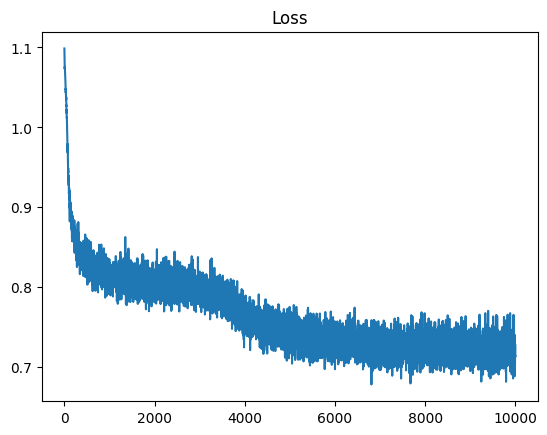

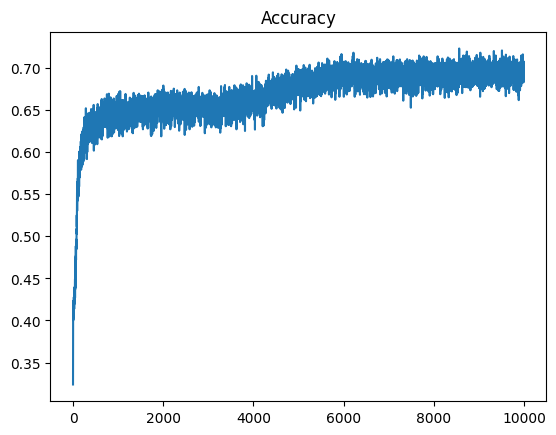

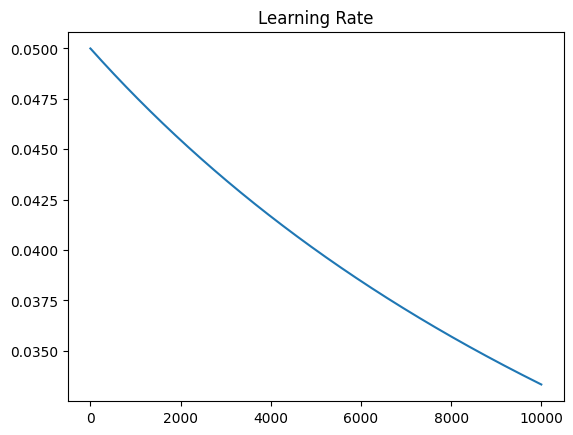

validation, acc: 0.767, loss: 0.654


In [7]:
import numpy as np
import nnfs
from nnfs.datasets import spiral_data
import matplotlib.pyplot as plt

nnfs.init()


# Dense layer
class Layer_Dense:

    # Layer initialization
    def __init__(self, n_inputs, n_neurons,
                 weight_regularizer_l1=0, weight_regularizer_l2=0,
                 bias_regularizer_l1=0, bias_regularizer_l2=0):
        # Initialize weights and biases
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

        # Set regularization strength
        self.weight_regularizer_l1 = weight_regularizer_l1
        self.weight_regularizer_l2 = weight_regularizer_l2
        self.bias_regularizer_l1 = bias_regularizer_l1
        self.bias_regularizer_l2 = bias_regularizer_l2

    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from inputs, weights and biases
        self.output = np.dot(inputs, self.weights) + self.biases

    # Backward pass
    def backward(self, dvalues):
        # Gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)

        # Gradients on regularization
        # L1 on weights
        if self.weight_regularizer_l1 > 0:
            dL1 = np.ones_like(self.weights)
            dL1[self.weights < 0] = -1
            self.dweights += self.weight_regularizer_l1 * dL1
        # L2 on weights
        if self.weight_regularizer_l2 > 0:
            self.dweights += 2 * self.weight_regularizer_l2 * \
                             self.weights
        # L1 on biases
        if self.bias_regularizer_l1 > 0:
            dL1 = np.ones_like(self.biases)
            dL1[self.biases < 0] = -1
            self.dbiases += self.bias_regularizer_l1 * dL1
        # L2 on biases
        if self.bias_regularizer_l2 > 0:
            self.dbiases += 2 * self.bias_regularizer_l2 * \
                            self.biases

        # Gradient on values
        self.dinputs = np.dot(dvalues, self.weights.T)


# Dropout
class Layer_Dropout:

    # Init
    def __init__(self, rate):
        # Store rate, we invert it as for example for dropout
        # of 0.1 we need success rate of 0.9
        self.rate = 1 - rate

    # Forward pass
    def forward(self, inputs):
        # Save input values
        self.inputs = inputs
        # Generate and save scaled mask
        self.binary_mask = np.random.binomial(1, self.rate,
                           size=inputs.shape) / self.rate
        # Apply mask to output values
        self.output = inputs * self.binary_mask

    # Backward pass
    def backward(self, dvalues):
        # Gradient on values
        self.dinputs = dvalues * self.binary_mask


# ReLU activation
class Activation_ReLU:

    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from inputs
        self.output = np.maximum(0, inputs)

    # Backward pass
    def backward(self, dvalues):
        # Since we need to modify original variable,
        # let's make a copy of values first
        self.dinputs = dvalues.copy()

        # Zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0



# Softmax activation
class Activation_Softmax:

    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs

        # Get unnormalized probabilities
        exp_values = np.exp(inputs - np.max(inputs, axis=1,
                                            keepdims=True))
        # Normalize them for each sample
        probabilities = exp_values / np.sum(exp_values, axis=1,
                                            keepdims=True)

        self.output = probabilities

    # Backward pass
    def backward(self, dvalues):

        # Create uninitialized array
        self.dinputs = np.empty_like(dvalues)

        # Enumerate outputs and gradients
        for index, (single_output, single_dvalues) in \
                enumerate(zip(self.output, dvalues)):
            # Flatten output array
            single_output = single_output.reshape(-1, 1)
            # Calculate Jacobian matrix of the output
            jacobian_matrix = np.diagflat(single_output) - \
                              np.dot(single_output, single_output.T)
            # Calculate sample-wise gradient
            # and add it to the array of sample gradients
            self.dinputs[index] = np.dot(jacobian_matrix,
                                         single_dvalues)


# SGD optimizer
class Optimizer_SGD:

    # Initialize optimizer - set settings,
    # learning rate of 1. is default for this optimizer
    def __init__(self, learning_rate=1., decay=0., momentum=0.):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):

        # If we use momentum
        if self.momentum:

            # If layer does not contain momentum arrays, create them
            # filled with zeros
            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                # If there is no momentum array for weights
                # The array doesn't exist for biases yet either.
                layer.bias_momentums = np.zeros_like(layer.biases)

            # Build weight updates with momentum - take previous
            # updates multiplied by retain factor and update with
            # current gradients
            weight_updates = \
                self.momentum * layer.weight_momentums - \
                self.current_learning_rate * layer.dweights
            layer.weight_momentums = weight_updates

            # Build bias updates
            bias_updates = \
                self.momentum * layer.bias_momentums - \
                self.current_learning_rate * layer.dbiases
            layer.bias_momentums = bias_updates

        # Vanilla SGD updates (as before momentum update)
        else:
            weight_updates = -self.current_learning_rate * \
                             layer.dweights
            bias_updates = -self.current_learning_rate * \
                           layer.dbiases

        # Update weights and biases using either
        # vanilla or momentum updates
        layer.weights += weight_updates
        layer.biases += bias_updates

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1
# Adagrad optimizer
class Optimizer_Adagrad:

    # Initialize optimizer - set settings
    def __init__(self, learning_rate=1., decay=0., epsilon=1e-7):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):

        # If layer does not contain cache arrays,
        # create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update cache with squared current gradients
        layer.weight_cache += layer.dweights**2
        layer.bias_cache += layer.dbiases**2

        # Vanilla SGD parameter update + normalization
        # with square rooted cache
        layer.weights += -self.current_learning_rate * \
                         layer.dweights / \
                         (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * \
                        layer.dbiases / \
                        (np.sqrt(layer.bias_cache) + self.epsilon)

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1



# RMSprop optimizer
class Optimizer_RMSprop:

    # Initialize optimizer - set settings
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7,
                 rho=0.9):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.rho = rho

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):

        # If layer does not contain cache arrays,
        # create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update cache with squared current gradients
        layer.weight_cache = self.rho * layer.weight_cache + \
            (1 - self.rho) * layer.dweights**2
        layer.bias_cache = self.rho * layer.bias_cache + \
            (1 - self.rho) * layer.dbiases**2

        # Vanilla SGD parameter update + normalization
        # with square rooted cache
        layer.weights += -self.current_learning_rate * \
                         layer.dweights / \
                         (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * \
                        layer.dbiases / \
                        (np.sqrt(layer.bias_cache) + self.epsilon)

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1



# Adam optimizer
class Optimizer_Adam:

    # Initialize optimizer - set settings
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7,
                 beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):

        # If layer does not contain cache arrays,
        # create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update momentum  with current gradients
        layer.weight_momentums = self.beta_1 * \
                                 layer.weight_momentums + \
                                 (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * \
                               layer.bias_momentums + \
                               (1 - self.beta_1) * layer.dbiases
        # Get corrected momentum
        # self.iteration is 0 at first pass
        # and we need to start with 1 here
        weight_momentums_corrected = layer.weight_momentums / \
            (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / \
            (1 - self.beta_1 ** (self.iterations + 1))
        # Update cache with squared current gradients
        layer.weight_cache = self.beta_2 * layer.weight_cache + \
            (1 - self.beta_2) * layer.dweights**2

        layer.bias_cache = self.beta_2 * layer.bias_cache + \
            (1 - self.beta_2) * layer.dbiases**2
        # Get corrected cache
        weight_cache_corrected = layer.weight_cache / \
            (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / \
            (1 - self.beta_2 ** (self.iterations + 1))

        # Vanilla SGD parameter update + normalization
        # with square rooted cache
        layer.weights += -self.current_learning_rate * \
                         weight_momentums_corrected / \
                         (np.sqrt(weight_cache_corrected) +
                             self.epsilon)
        layer.biases += -self.current_learning_rate * \
                         bias_momentums_corrected / \
                         (np.sqrt(bias_cache_corrected) +
                             self.epsilon)

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1


# Common loss class
class Loss:

    # Regularization loss calculation
    def regularization_loss(self, layer):

        # 0 by default
        regularization_loss = 0

        # L1 regularization - weights
        # calculate only when factor greater than 0
        if layer.weight_regularizer_l1 > 0:
            regularization_loss += layer.weight_regularizer_l1 * \
                                   np.sum(np.abs(layer.weights))

        # L2 regularization - weights
        if layer.weight_regularizer_l2 > 0:
            regularization_loss += layer.weight_regularizer_l2 * \
                                   np.sum(layer.weights * \
                                          layer.weights)


        # L1 regularization - biases
        # calculate only when factor greater than 0
        if layer.bias_regularizer_l1 > 0:
            regularization_loss += layer.bias_regularizer_l1 * \
                                   np.sum(np.abs(layer.biases))

        # L2 regularization - biases
        if layer.bias_regularizer_l2 > 0:
            regularization_loss += layer.bias_regularizer_l2 * \
                                   np.sum(layer.biases * \
                                          layer.biases)

        return regularization_loss

    # Calculates the data and regularization losses
    # given model output and ground truth values
    def calculate(self, output, y):

        # Calculate sample losses
        sample_losses = self.forward(output, y)

        # Calculate mean loss
        data_loss = np.mean(sample_losses)

        # Return loss
        return data_loss


# Cross-entropy loss
class Loss_CategoricalCrossentropy(Loss):

    # Forward pass
    def forward(self, y_pred, y_true):

        # Number of samples in a batch
        samples = len(y_pred)

        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        # Probabilities for target values -
        # only if categorical labels
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[
                range(samples),
                y_true
            ]

        # Mask values - only for one-hot encoded labels
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(
                y_pred_clipped * y_true,
                axis=1
            )

        # Losses
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods

    # Backward pass
    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)
        # Number of labels in every sample
        # We'll use the first sample to count them
        labels = len(dvalues[0])

        # If labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        # Calculate gradient
        self.dinputs = -y_true / dvalues
        # Normalize gradient
        self.dinputs = self.dinputs / samples


# Softmax classifier - combined Softmax activation
# and cross-entropy loss for faster backward step
class Activation_Softmax_Loss_CategoricalCrossentropy():

    # Creates activation and loss function objects
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()

    # Forward pass
    def forward(self, inputs, y_true):
        # Output layer's activation function
        self.activation.forward(inputs)
        # Set the output
        self.output = self.activation.output
        # Calculate and return loss value
        return self.loss.calculate(self.output, y_true)


    # Backward pass
    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)

        # If labels are one-hot encoded,
        # turn them into discrete values
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)

        # Copy so we can safely modify
        self.dinputs = dvalues.copy()
        # Calculate gradient
        self.dinputs[range(samples), y_true] -= 1
        # Normalize gradient
        self.dinputs = self.dinputs / samples


# Create dataset
X, y = spiral_data(samples=1000, classes=3)
plt.scatter(X[:,0], X[:,1], c=y)
plt.show()

# Create Dense layer with 2 input features and 64 output values
dense1 = Layer_Dense(2, 64, weight_regularizer_l2=5e-4,
                            bias_regularizer_l2=5e-4)

# Create ReLU activation (to be used with Dense layer):
activation1 = Activation_ReLU()

# Create dropout layer
dropout1 = Layer_Dropout(0.1)

# Create second Dense layer with 64 input features (as we take output
# of previous layer here) and 3 output values (output values)
dense2 = Layer_Dense(64, 3)

# Create Softmax classifier's combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

# Create optimizer
optimizer = Optimizer_Adam(learning_rate=0.05, decay=5e-5)   # 0.02, 5e-7

losses = []
accuracies = []
learning_rates = []

# Train in loop
for epoch in range(10001):
    # Perform a forward pass of our training data through this layer
    dense1.forward(X)

    # Perform a forward pass through activation function
    # takes the output of first dense layer here
    activation1.forward(dense1.output)

    # Perform a forward pass through Dropout layer
    dropout1.forward(activation1.output)

    # Perform a forward pass through second Dense layer
    # takes outputs of activation function of first layer as inputs
    dense2.forward(dropout1.output)

    # Perform a forward pass through the activation/loss function
    # takes the output of second dense layer here and returns loss
    data_loss = loss_activation.forward(dense2.output, y)

    # Calculate regularization penalty
    regularization_loss = \
        loss_activation.loss.regularization_loss(dense1) + \
        loss_activation.loss.regularization_loss(dense2)

    # Calculate overall loss
    loss = data_loss + regularization_loss
    losses.append(loss)

    # Calculate accuracy from output of activation2 and targets
    # calculate values along first axis
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions==y)
    accuracies.append(accuracy)
    
    learning_rates.append(optimizer.current_learning_rate)
    if not epoch % 100:
        print(f'epoch: {epoch}, ' +
              f'acc: {accuracy:.3f}, ' +
              f'loss: {loss:.3f} (' +
              f'data_loss: {data_loss:.3f}, ' +
              f'reg_loss: {regularization_loss:.3f}), ' +
              f'lr: {optimizer.current_learning_rate}')

    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    dropout1.backward(dense2.dinputs)
    activation1.backward(dropout1.dinputs)
    dense1.backward(activation1.dinputs)

    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()
    
plt.plot(range(10001), losses)
plt.title('Loss')
plt.show()
plt.plot(range(10001), accuracies)
plt.title('Accuracy')
plt.show()
plt.plot(range(10001), learning_rates)
plt.title('Learning Rate')
plt.show()

# Validate the model
# Create test dataset
X_test, y_test = spiral_data(samples=100, classes=3)

# Perform a forward pass of our testing data through this layer
dense1.forward(X_test)

# Perform a forward pass through activation function
# takes the output of first dense layer here
activation1.forward(dense1.output)

# Perform a forward pass through second Dense layer
# takes outputs of activation function of first layer as inputs
dense2.forward(activation1.output)

# Perform a forward pass through the activation/loss function
# takes the output of second dense layer here and returns loss
loss = loss_activation.forward(dense2.output, y_test)

# Calculate accuracy from output of activation2 and targets
# calculate values along first axis
predictions = np.argmax(loss_activation.output, axis=1)
if len(y_test.shape) == 2:
    y_test = np.argmax(y_test, axis=1)
accuracy = np.mean(predictions==y_test)

print(f'validation, acc: {accuracy:.3f}, loss: {loss:.3f}')

Pretty good result, but worse compared to the “no dropout” model.

Interestingly, validation accuracy is close to the training accuracy with dropout — usually validation accuracy will be higher, so we might suspect these as signs of overfitting here (validation loss is lower than expected).

<center><img src='./image/15-4.png' style='width: 70%'/><font color='gray'><i>Model trained with dropout and bigger hidden layer.</i></font></center>
